# Collaboration and Competition with MADDPG

---

### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="./Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Performance of a Random Model

In [4]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


### 4. Hyperparameters

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Hyperparameters

buffer_size = int(1e5)

seed = 3

batch_size = 128 
update_every = 1 
gamma = 1.0 # discount 
tau = 0.001
actor_learning_rate = 1e-4
critic_learning_rate = 1e-4 
critic_weight_decay = 0
fc1_dim = 256 
fc2_dim = 128 

cpu


### 5. Class Definitions

In [6]:
# Actor - Policy
class Actor(nn.Module):
    def __init__(self, action_size, state_size, seed, fc1_dim=400, fc2_dim=300):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_dim)
        self.fc2 = nn.Linear(fc1_dim, fc2_dim)
        self.output = nn.Linear(fc2_dim, action_size)
        self.tanh = nn.Tanh()
        self.reset_parameters(fc1_dim, fc2_dim)
        
    def reset_parameters(self, fc1_dim, fc2_dim):
        self.fc1.weight.data.uniform_(-1./math.sqrt(fc1_dim), 1./math.sqrt(fc1_dim))
        self.fc2.weight.data.uniform_(-1./math.sqrt(fc2_dim), 1./math.sqrt(fc2_dim))
        self.output.weight.data.uniform_(-3e-3, 3e-3)
        self.output.bias.data.uniform_(3e-4, 3e-4)
        
    def forward(self, states):
        x = states
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.tanh(self.output(x))

In [7]:
# Critic - Q Value
class Critic(nn.Module):
    def __init__(self, action_size, state_size, seed, fc1_dim=400, fc2_dim=300):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_dim)
        self.fc2 = nn.Linear(fc1_dim+action_size, fc2_dim)
        self.output = nn.Linear(fc2_dim, 1)
        self.reset_parameters(fc1_dim, fc2_dim+action_size)
        
    def reset_parameters(self, fc1_dim, fc2_dim):
        self.fc1.weight.data.uniform_(-1./math.sqrt(fc1_dim), 1./math.sqrt(fc1_dim))
        self.fc2.weight.data.uniform_(-1./math.sqrt(fc2_dim), 1./math.sqrt(fc2_dim))
        self.output.weight.data.uniform_(-3e-3, 3e-3)
        self.output.bias.data.uniform_(3e-4, 3e-4)
        
    def forward(self, states, actions):
        xs = states
        xs = F.relu(self.fc1(xs))
        x = torch.cat((xs, actions), dim=1)
        x = F.relu(self.fc2(x))
        return self.output(x)

In [8]:
# ReplayBuffer
from collections import namedtuple, deque
import random

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""
    def __init__(self, action_size, buffer_size, batch_size, seed, device):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.device = device
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    
memory = ReplayBuffer(action_size, buffer_size, batch_size, seed, device)

In [9]:
# Noise
import copy
import numpy as np
import random

class OrnsteinUhlenbeckNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.size = size
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state        
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

In [10]:
# DDPGAgent
class DDPGAgent:
    def __init__(self, action_size, state_size, seed, fc1_dim, fc2_dim, actor_learning_rate, critic_learning_rate,
                 critic_weight_decay, device, gamma, tau):
        """Initialize all parameters."""

        self.actor_local = Actor(action_size, state_size, seed, fc1_dim, fc2_dim).to(device)
        self.actor_target = Actor(action_size, state_size, seed, fc1_dim, fc2_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor_local.parameters(), lr=actor_learning_rate)
        
        self.critic_local = Critic(action_size, state_size, seed, fc1_dim, fc2_dim).to(device)
        self.critic_target = Critic(action_size, state_size, seed, fc1_dim, fc2_dim).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic_local.parameters(), lr=critic_learning_rate,
                                                 weight_decay=critic_weight_decay)
        
        self.noise = OrnsteinUhlenbeckNoise(action_size, seed)
        self.gamma = gamma
        self.tau = tau
        self.t_step = 0
        
    def reset(self):
        self.noise.reset()
        
    def act(self, states, device, train_mode=False):
        states = torch.from_numpy(states).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
        self.actor_local.train()
        
        if train_mode:
            actions += self.noise.sample()
        return np.clip(actions, -1, 1)
    
    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # Update Critic
        next_actions = self.actor_target(next_states)
        q_targets_next = self.critic_target(next_states, next_actions)
        q_targets = rewards + (self.gamma * q_targets_next * (1 - dones))
        q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(q_expected, q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        # Update Actor
        actions_expected = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_expected).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.actor_local, self.actor_target, self.tau)
        self.soft_update(self.critic_local, self.critic_target, self.tau)
        
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [11]:
# MADDPG
class MADDPG:
    def __init__(self, action_size, state_size, batch_size, seed, fc1_dim, fc2_dim, actor_learning_rate,
                 critic_learning_rate, critic_weight_decay, memory, device, num_agents, update_every, gamma, tau):
        super(MADDPG, self).__init__()

        self.ddpg_agents = [DDPGAgent(action_size, state_size, seed, fc1_dim, fc2_dim, actor_learning_rate, 
                                      critic_learning_rate, critic_weight_decay, device, gamma,
                                      tau) for _ in range(num_agents)]

        self.memory = memory          
        self.update_every = update_every
        self.batch_size = batch_size
        
        self.t_step = 0
     
    def reset(self):
        for agent in self.ddpg_agents:
            agent.reset()

    def act(self, all_states, device, train_mode=False):
        """get actions from all agents in the MADDPG object"""
        actions = [agent.act(np.expand_dims(states, axis=0), device,
                             train_mode) for agent, states in zip(self.ddpg_agents, all_states)]
        return actions
    
    def step(self, states, actions, rewards, next_states, dones):
        # Save experience in replay memory
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                for agent in self.ddpg_agents:
                    experiences = self.memory.sample()
                    
                    agent.learn(experiences)

maddpg = MADDPG(action_size, state_size, batch_size, seed, fc1_dim, fc2_dim, actor_learning_rate,
                critic_learning_rate, critic_weight_decay, memory, device, num_agents, update_every, gamma, tau)

### 6. Train the Model

In [12]:
import os
from workspace_utils import keep_awake
import datetime
import time


avg_over = 100
print_every = 10

n_episodes=30000
max_t=2000

print('Start: ', datetime.datetime.now())
scores_deque = deque(maxlen=avg_over)
scores_global = []
average_global = []
min_global = []    
best_avg = -np.inf

scores_window = deque(maxlen=100)

tic = time.time()
print('\rNo,Score,  Avg,  Min, Time, Buffer')
for i_episode in keep_awake(range(1, n_episodes+1)):

    maddpg.reset()
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations    
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)

    score_average = 0
    timestep = time.time()
    for i in range(max_t):
        actions = maddpg.act(states, device, train_mode=True)
        env_info = env.step(actions)[brain_name]
        rewards = env_info.rewards
        next_states = env_info.vector_observations
        dones = env_info.local_done

        maddpg.step(states, actions, rewards, next_states, dones)

        scores += rewards
        states = next_states
        if np.any(dones):                                  # exit loop if episode finished
            break
    
    score = np.max(scores)
    
    scores_deque.append(score)
    score_average = np.mean(scores_deque)
    scores_global.append(score)
    average_global.append(score_average)  
    min_global.append(np.min(scores))  

    if i_episode % print_every == 0:
        torch.save(maddpg.ddpg_agents[0].actor_local.state_dict(), str(i_episode) + '_checkpoint_actor.pth')
        torch.save(maddpg.ddpg_agents[0].critic_local.state_dict(), str(i_episode) + '_checkpoint_critic.pth')
        print('\r {}, {:.2f}, {:.2f}, {:.2f}, {:.2f}'\
          .format(str(i_episode).zfill(3), score, score_average, 
                  np.min(scores), time.time() - timestep), len(memory), end="\n")
    if  score_average > 0.5:            
        toc = time.time()
        print('\nSolved in {:d} episodes!\tAvg Score: {:.2f}, time: {}'.format(i_episode, score_average, toc-tic))
        torch.save(maddpg.ddpg_agents[0].actor_local.state_dict(), str(i_episode) + '_checkpoint_actor.pth')
        torch.save(maddpg.ddpg_agents[0].critic_local.state_dict(), str(i_episode) + '_checkpoint_critic.pth')
        break

print('End: ', datetime.datetime.now())

Start:  2019-07-16 05:41:30.585498
No,Score,  Avg,  Min, Time, Buffer
 010, 0.00, 0.01, -0.01, 0.48 338
 020, 0.00, 0.01, -0.01, 0.29 622
 030, 0.00, 0.00, -0.01, 0.28 906
 040, 0.00, 0.00, -0.01, 0.28 1190
 050, 0.00, 0.00, -0.01, 0.30 1474
 060, 0.00, 0.00, -0.01, 0.30 1758
 070, 0.00, 0.00, -0.01, 0.30 2042
 080, 0.00, 0.00, -0.01, 0.31 2326
 090, 0.00, 0.00, -0.01, 0.29 2610
 100, 0.00, 0.00, -0.01, 0.29 2894
 110, 0.00, 0.00, -0.01, 0.30 3178
 120, 0.00, 0.00, -0.01, 0.31 3462
 130, 0.00, 0.00, -0.01, 0.31 3746
 140, 0.00, 0.00, -0.01, 0.30 4030
 150, 0.00, 0.00, -0.01, 0.30 4314
 160, 0.00, 0.00, -0.01, 0.30 4598
 170, 0.00, 0.00, -0.01, 0.30 4882
 180, 0.00, 0.00, -0.01, 0.29 5166
 190, 0.00, 0.00, -0.01, 0.31 5450
 200, 0.00, 0.00, -0.01, 0.29 5734
 210, 0.00, 0.00, -0.01, 0.30 6018
 220, 0.00, 0.00, -0.01, 0.31 6302
 230, 0.00, 0.00, -0.01, 0.29 6586
 240, 0.00, 0.00, -0.01, 0.31 6870
 250, 0.00, 0.00, -0.01, 0.31 7154
 260, 0.00, 0.00, -0.01, 0.32 7438
 270, 0.00, 0.00, -0.01

In [19]:
torch.save(maddpg.ddpg_agents[0].actor_local.state_dict(), 'final_checkpoint_actor0.pth')
torch.save(maddpg.ddpg_agents[0].critic_local.state_dict(), 'final_checkpoint_critic0.pth')
torch.save(maddpg.ddpg_agents[1].actor_local.state_dict(), 'final_checkpoint_actor1.pth')
torch.save(maddpg.ddpg_agents[1].critic_local.state_dict(), 'final_checkpoint_critic1.pth')

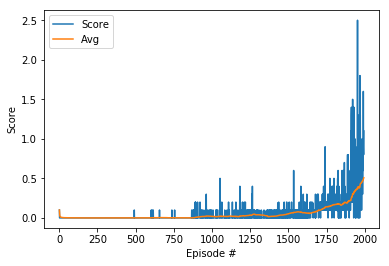

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

scores = scores_global
averages = average_global

plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(1, len(averages)+1), averages)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(['Score','Avg'], loc='upper left')
plt.show()

### 7. Load & Test our Trained Model

In [11]:
def hard_copy(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

def load(agent, actor_file, critic_file):
    agent.actor_local.load_state_dict(torch.load(actor_file, map_location=lambda storage, loc: storage))
    agent.critic_local.load_state_dict(torch.load(critic_file, map_location=lambda storage, loc: storage))
    hard_copy(agent.actor_target, agent.actor_local)
    hard_copy(agent.critic_target, agent.critic_local)

agent = DDPGAgent(action_size, state_size, seed, fc1_dim, fc2_dim, actor_learning_rate, critic_learning_rate,
                  critic_weight_decay, device, gamma, tau)
load(agent, 'final_checkpoint_actor0.pth', 'final_checkpoint_critic0.pth')

In [11]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = agent.act(states, device, train_mode=False)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 1.1950000179931521
Total score (averaged over agents) this episode: 1.6950000254437327
Total score (averaged over agents) this episode: 2.600000038743019
Total score (averaged over agents) this episode: 2.650000039488077
Total score (averaged over agents) this episode: 1.145000017248094


When finished, you can close the environment.

In [13]:
env.close()